In [ ]:
import os
import numpy as np
import random
import pandas as pd
import sys 

from PIL import Image
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
import matplotlib.pyplot as plt
import kagglehub

from Excel_data import Excel_data

from constants import excel_filename, dataset_name
from modelos.RegresionLogistica import regresion_logistica
from modelos.CNN import cnn1, cnn2
from modelos.KNN import knn
from modelos.ArbolDeDecision import arbol_decision

## guardar datos en excel ##
def save_to_excel(datos):
    # Si el archivo ya existe, se leerá y se agregará nueva información
    metodo =  datos.pop("Método")
    if os.path.exists(excel_filename):
        results = pd.read_excel(excel_filename, index_col=0)
        df = pd.DataFrame(datos, index=metodo)
        results = pd.concat([results, df], ignore_index=False)
        results.to_excel(excel_filename)
    else:
        results = pd.DataFrame(datos)
        results.index = metodo
        results.to_excel(excel_filename)

#función para hacer la gráfica después de evaluar el rendimiento
def plot_rendimiento(exactitud, sensibilidad, precision, matriz_confusion, clases, fpr_micro, tpr_micro, roc_auc_micro, fpr, tpr, roc_auc):
    # Imprimir métricas de evaluación
    print("Exactitud    : %.2f %%" % exactitud)
    print("Sensibilidad : %.2f %%" % sensibilidad)
    print("Precisión    : %.2f %%" % precision)

    #matriz de confusion
    disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusion, display_labels=clases)
    disp.plot()
    disp.figure_.suptitle("Matriz de confusión")
    disp.figure_.set_dpi(100)
    plt.xlabel("Clase predicha")
    plt.ylabel("Clase real")
    plt.show()

    #roc y auc
    plt.figure()
    plt.plot(fpr_micro, tpr_micro, color='red', lw=2, label='Curva ROC micro-average (AUC = %0.3f)' % roc_auc_micro)
    plt.plot([0, 1], [0, 1], color='k', lw=1, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.legend(loc="lower right")
    plt.show()

    # Curvas ROC por clase
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'blue', 'violet', 'gold', 'orange', 'pink', 'tan', 'purple', 'lime', 'red']
    for i in range(len(clases)):
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=1, label='ROC clase %i (area = %0.3f)' % (i, roc_auc[i]))

    plt.plot(fpr_micro, tpr_micro, color='red', lw=2, linestyle=':', label='Curva ROC micro-average (AUC = %0.3f)' % roc_auc_micro)
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curva ROC por clase')
    plt.legend(loc="lower right")
    plt.show()

## evaluar rendimiento ##
def evaluar_rendimiento(model, X_test, y_test, nombre_metodo, pca):
    # Aplanar las imágenes de prueba
    X_test_flat = X_test.reshape(X_test.shape[0], -1)  # Aplanar a 2D: [n_samples, n_features]
    
    # Normalizar los datos de prueba (debe coincidir con la normalización de X_train)
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test_flat)
    
    # Aplicar PCA al conjunto de prueba (debe ser la misma transformación que en el entrenamiento)
    if pca is not None:
        X_test_pca = pca.transform(X_test_scaled)  # Aquí usamos el PCA entrenado para transformar X_test
    else:
        X_test_pca = model.pca.transform(X_test_scaled)  # Aquí usamos el PCA entrenado para transformar X_test

    # Hacer predicciones
    y_pred = model.predict(X_test_pca)

    # Métricas de rendimiento
    precision = 100 * accuracy_score(y_test, y_pred)
    sensibility = 100 * recall_score(y_test, y_pred, average='macro')
    precision_score_value = 100 * precision_score(y_test, y_pred, average='macro')

    # Informe de clasificación
    print("Informe de evaluación del clasificador sobre el conjunto de test:\n", classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # ROC y AUC
    n_classes = len(np.unique(y_test))
    y_test_bin = label_binarize(y_test, classes=np.arange(0, n_classes, 1))
    y_score = model.predict_proba(X_test_pca)

    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # ROC por clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Aquí iría la función para guardar en Excel (asegúrate de que 'Excel_data' y 'save_to_excel' están bien implementadas)
    datos = {
        "Método": [nombre_metodo],
        "Exactitud": [100 * accuracy_score(y_test, y_pred)],
        "Precisión": [100 * precision_score(y_test, y_pred, average='macro')],
        "Matriz de confusión": [cm],
        "fpr_micro": [fpr_micro],
        "tpr_micro": [tpr_micro],
        "roc_auc_micro": [roc_auc_micro],
        "fpr": [fpr],
        "tpr": [tpr],
        "roc_auc": [roc_auc]
    }
    save_to_excel(datos)
    # plot rendimiento
    plot_rendimiento(
        precision,
        sensibility,
        precision_score_value,
        cm,
        model.classes_,
        fpr_micro,
        tpr_micro,
        roc_auc_micro,
        fpr,
        tpr,
        roc_auc
    )


## cargar imágenes ##
def cargar_imagenes(image_path, target_size=(256, 256), channel_mode="rgb"):

    img_list = []
    labels = []
    classes = os.listdir(image_path)

    for folder in classes:
        folder_path = os.path.join(image_path, folder)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.png', '.jpeg')):
                    img = Image.open(os.path.join(folder_path, filename)).convert("RGB")
                    img_array = np.array(img)

                    # Redimensionar
                    img_resized = resize(img_array, target_size, anti_aliasing=True)

                    # Modos de canal
                    if channel_mode == "grayscale":
                        img_resized = rgb2gray(img_resized)  # Convertir a escala de grises
                    elif channel_mode == "r":  # Canal rojo
                        img_resized = img_resized[:, :, 0]
                    elif channel_mode == "g":  # Canal verde
                        img_resized = img_resized[:, :, 1]
                    elif channel_mode == "b":  # Canal azul
                        img_resized = img_resized[:, :, 2]
                    elif channel_mode == "rgb":
                        img_resized = (img_resized * 255).astype(np.uint8)  # Restaurar valores de píxeles

                    img_resized = img_resized / 255.0  # Normalizar
                    img_list.append(img_resized)
                    labels.append(folder)  # Guardar etiqueta

    return np.array(img_list), np.array(labels)        


In [12]:
path = kagglehub.dataset_download(dataset_name)

# cargar train y test
X_train_rgb, y_train = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="rgb")
X_test_rgb, y_test = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="rgb")
X_train_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), channel_mode="grayscale")
X_test_gray, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), channel_mode="grayscale")
X_train_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/train'), target_size=(64, 64))
X_test_rgb_64, _ = cargar_imagenes(os.path.join(path, 'flowers/flowers/flower_photos/test'), target_size=(64, 64))

# Codificar etiquetas
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

epochs = 100
batch_size = 100
history = []

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def knn(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded):
    X_train_flattened = X_train_rgb.reshape(X_train_rgb.shape[0], -1)
    X_test_flattened = X_test_rgb.reshape(X_test_rgb.shape[0], -1)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_flattened)
    X_test_scaled = scaler.transform(X_test_flattened)
    
    pca = PCA(n_components=50)  # You can adjust n_components as needed
    X_train_pca = pca.fit_transform(X_train_scaled)
    #X_test_pca = pca.transform(X_test_scaled)
    
    knn_model = KNeighborsClassifier(n_neighbors=3)
    knn_model.fit(X_train_pca, y_train_encoded)
    
    # Return both the trained KNN model and PCA model as a tuple
    return knn_model, pca


In [80]:
modelKNN, pcaKNN = knn(X_train_rgb, y_train_encoded, X_test_rgb, y_test_encoded)


KeyboardInterrupt: 

Informe de evaluación del clasificador sobre el conjunto de test:
               precision    recall  f1-score   support

           0       0.50      0.50      0.50        10
           1       0.22      0.40      0.29        10
           2       0.75      0.30      0.43        10
           3       0.50      0.30      0.38        10
           4       0.33      0.40      0.36        10

    accuracy                           0.38        50
   macro avg       0.46      0.38      0.39        50
weighted avg       0.46      0.38      0.39        50

Exactitud    : 38.00 %
Sensibilidad : 38.00 %
Precisión    : 46.11 %


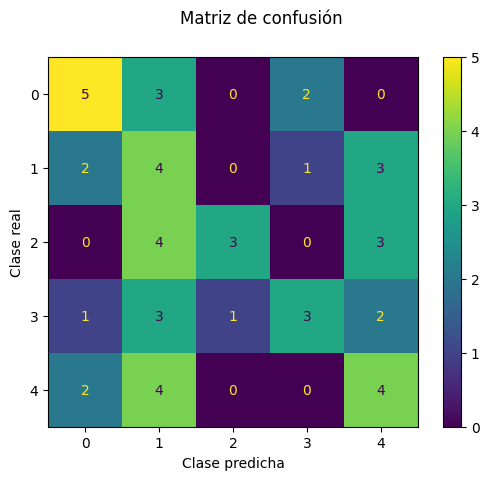

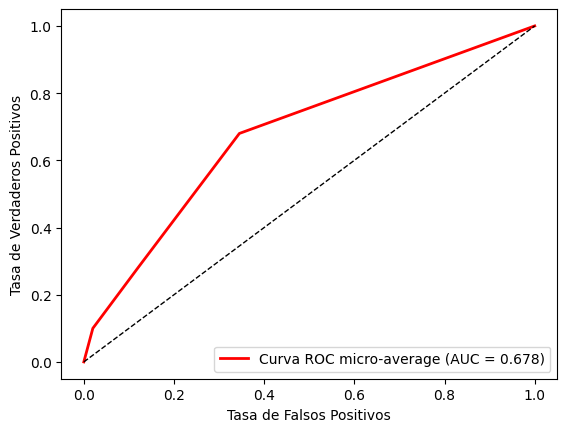

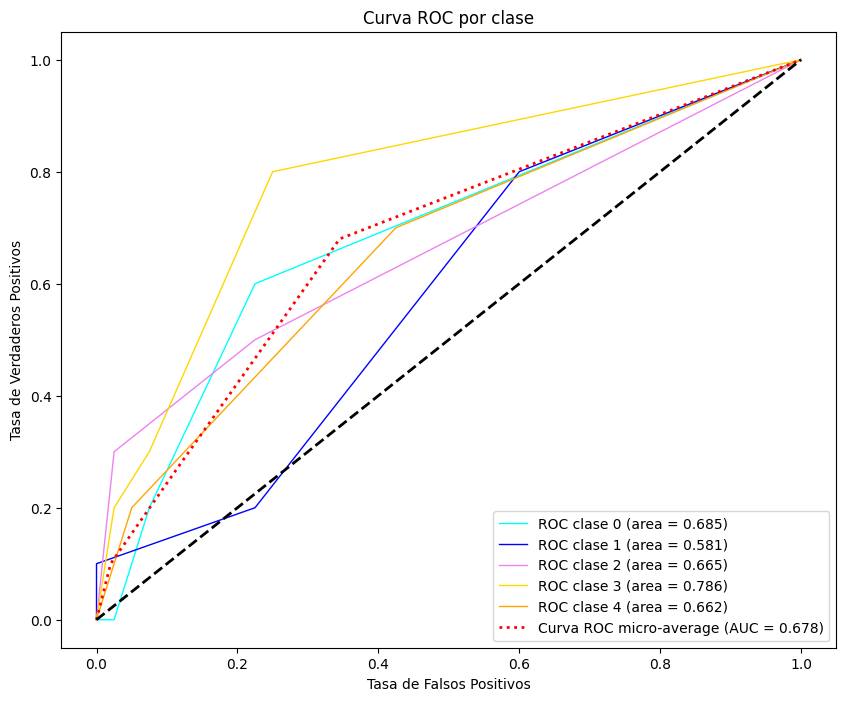

In [124]:
evaluar_rendimiento(modelKNN, X_test_rgb, y_test_encoded, "KNN", pcaKNN)
